This file creates two groups of models for two different subsets of the same dataset. The dataset is on the topic of heart disease. It was acquired through the API of https://data.world/uci/heart-disease using their python package "datadotworld".

The dataset initially consisted of four sets for Hungary, Long Beach, Switzerland and Cleveland, which were combined into one.

The 'bad columns' subset refers to features that require no medical examination. The quentions include age, sex, smoking, family history of heart disease, family history of diabetes, etc.

The 'better columns' subset consists of medical metrics collected by professionals during patient examination. Better columns resulted in better recall for the models.

Conclusion: Consult your doctor. Do not rely purely on the features from the 'bad columns' subset. Diagnosis requires medical examination.

In [128]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import joblib
import datetime
import random
import seaborn as sns

In [131]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB   
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2, SelectFromModel
from sklearn.svm import LinearSVC

In [130]:
import hearty

### Defining scorers for use in Grid Search (currently only f1_scorer is used)

In [3]:
acc_scorer = make_scorer(accuracy_score)
f1_scorer = make_scorer(f1_score, average='macro')
recall_scorer = make_scorer(recall_score, average='macro')
precision_scorer = make_scorer(precision_score, average='macro')

## Defining classes and functions

In [178]:
def prepare_data(data):
    
    # Shuffling data now to later split without shuffling
    shuffled_cols_index = list(data.index)
    random.shuffle(shuffled_cols_index)
    data = data.iloc[shuffled_cols_index, :]
    
    # Splitting data into X and y
    X = data.drop(columns = [58])
    y = data[58]
    
    # Min-Max scaling the X data
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Replacing all 1,2,3,4 in y with 1 (i.e. if person has any degree of illness, replace degree with 1)
    y = y.apply(lambda x: 0 if x==0 else 1)
    
    # Splitting data into train and test
    data = train_test_split(X_scaled, y, test_size=0.3, shuffle=False)
    
    return data

In [160]:
class ModelHandler:
    
    def __init__(self, model, gs_params, data, model_params={}):
        self.X_train, self.X_test, self.y_train, self.y_test = data
        self.model = model
        self.gs_params = gs_params
        self.model_params = model_params
        self.f1_scorer = make_scorer(f1_score, average='macro')
        self.gs = self._get_gs()
        self.best_model = None


    def _get_gs(self):
        try:
            gs_model = self.model(**self.model_params)
            print(f'\nPerforming Grid Search on {gs_model.__class__.__name__}')
            gs = GridSearchCV(gs_model, self.gs_params, cv=5, verbose=10,  n_jobs=-1, refit=False, scoring = self.f1_scorer)
            gs.fit(self.X_train, self.y_train)
        except:
            gs = None
        return gs
        
    def get_best_model(self, fit=True):
        try:
            if self.gs == None:   #perform grid search if one isn't available
                self.gs = self._get_gs()
            best_model = self.model(**self.gs.best_params_, **self.model_params)   #define model using params from grid search
        except:   #if grid search is impossible, define model with standard params
            best_model = self.model(**self.model_params)
        if fit==True:   #fit the model before returning
            best_model.fit(self.X_train, self.y_train)
        self.best_model = best_model
        return best_model

    
    def predict(self, data):
        return self.best_model.predict(data)
    
    @staticmethod
    def clf_report(y_test, pred):
        return classification_report(y_test, pred)
    
    @staticmethod
    def conf_matrix(y_test, pred):
        return pd.DataFrame(confusion_matrix(y_test, pred))
    
    @staticmethod
    def accuracy(y_test, pred):
        return accuracy_score(y_test, pred)
    
    @staticmethod
    def f1(y_test, pred):
        return f1_score(y_test, pred, average='macro')
    
    @staticmethod
    def recall(y_test, pred):
        return recall_score(y_test, pred, average='macro')
    
    @staticmethod
    def precision(y_test, pred):
        return precision_score(y_test, pred, average='macro')        
     

In [161]:
def return_handlers(data, *models):
    handlers = {}
    
    # creating model handlers
    for model_tuple in models:
        model_name, model, params, model_settings = model_tuple
        handler = ModelHandler(model, params, data, model_settings)
        handlers[model_name] = handler
            
    # instantiating and fitting best models
    for model_name, handler in handlers.items():
        best_model = handler.get_best_model()
        handler.best_model = best_model
    
    # creating an additional voting classifier using all the fitted models above
    try:
        print("Training Voting Classifier using best models...")
        estimators = [(key, model) for key, model in return_best_models(**handlers).items()]
        model_params = dict(estimators=estimators, voting='hard')
        handler = ModelHandler(model = VotingClassifier, gs_params={'voting':['hard','soft']}, data=data, model_params=model_params)
        handler.best_model = VotingClassifier(**handler.gs.best_params_, **model_params)
        handler.best_model.fit(handler.X_train, handler.y_train)
        handlers['voting'] = handler
    except:
        pass

    return handlers

In [162]:
def return_best_models(**handlers):
    best_models = {}
    for model_name, handler in handlers.items():
        try:
            best_models[model_name] = handler.best_model
        except:
            handler.best_model = handler.get_best_model()
            best_models[model_name] = handler.best_model
    return best_models

In [189]:
def analyze_visualize(model_name, handlers):
    
    plt.figure(figsize=(4,4))

    print(f'\nStatistics and Confusion Matrix for model "{model_name}"')
    test_pred = handlers[ model_name ].predict(handlers[ model_name ].X_test)
    test_pred = pd.DataFrame(test_pred)
    test_pred_recall = recall_score(handlers[ model_name ].y_test, test_pred, average='macro')
    real = handlers[ model_name ].y_test

    # calc confusion matrix
    conf_matrix = handlers[ model_name ].conf_matrix(real, test_pred)
    conf_matrix = pd.DataFrame(conf_matrix)

    # print heatmap
    sns.heatmap(conf_matrix, annot=True, fmt="d")
    
    print(handlers[model_name].clf_report(real, test_pred))

In [199]:
def save_models(handlers, folder_path):
    for model_name, handler in handlers.items():
        model = handler.best_model
        now = datetime.datetime.today()
        now_str = now.strftime('%Y_%m_%d__%H_%M')
        filename = f"{folder_path}\\{model_name}__{now_str}.sav"
        joblib.dump(model, filename)    

### Preparing data

In [179]:
data_bad_cols = prepare_data(hearty.clean_bad_cols_df)
data_better_cols = prepare_data(hearty.clean_better_cols_df)

## Preparing models for Grid Search

In [164]:
# LogisticRegression
log_params = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
              'C':[0.001, 0.01, 0.1, 1, 10, 100]}
log_model_settings = dict(max_iter = 1000, multi_class='multinomial') 
log_tuple = ('lr', LogisticRegression, log_params, log_model_settings)  


# KNeighborsClassifier
knn_params = {'n_neighbors': [i for i in range(3,17,2)]}
knn_model_settings = dict()
knn_tuple = ('knn', KNeighborsClassifier, knn_params, knn_model_settings) 


# GaussianNB (grid search is not applicable to GaussianNB)
gauss_params = dict()
gauss_model_settings = dict()
gauss_tuple = ('gauss', GaussianNB, gauss_params, gauss_model_settings)


# SVC
svc_params = {'C':[1,10,100,1000],
              'gamma':[1,0.1,0.001,0.0001], 
              'kernel':['linear','rbf']}
svc_model_settings = dict()
svc_tuple = 'svc', SVC, svc_params, svc_model_settings


# DecisionTreeClassifier
d_tree_params = {'criterion':['gini','entropy'],
                 'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
d_tree_model_settings = dict()
d_tree_tuple = ('d_tree', DecisionTreeClassifier, d_tree_params, d_tree_model_settings)


# RandomForestClassifier
r_forest_params = {'n_estimators': [50, 150],
                    'max_features': ['sqrt', 0.25, 0.5, 0.75],
                    'min_samples_split': [2, 4, 6]}
r_forest_model_settings = dict()
r_forest_tuple = ('r_forest', RandomForestClassifier, r_forest_params, r_forest_model_settings)


# GradientBoostingClassifier
g_boost_params = {'learning_rate':[0.15,0.1,0.05,0.01], 
                  'n_estimators':[100,250,500,750]}
g_boost_settings = {}
g_boost_tuple = ('g_boost', GradientBoostingClassifier, g_boost_params, g_boost_settings)


# MLPClassifier
nn_params = {'hidden_layer_sizes': [(50, 25, 5)],
             'activation': ['tanh', 'relu'],
             'solver': ['sgd', 'adam'],
             'alpha': [0.0001, 0.05],
             'learning_rate': ['constant','adaptive']}
nn_model_settings = dict(max_iter=10000)
nn_tuple = ('nn', MLPClassifier, nn_params, nn_model_settings)

## Creating Handlers for 'bad columns' subset (the handler class performs grid search)

In [101]:
models = [log_tuple, knn_tuple, gauss_tuple, svc_tuple, d_tree_tuple, r_forest_tuple, g_boost_tuple, nn_tuple]
handlers_bad_cols = return_handlers(data_bad_cols, *models)

print(handlers_bad_cols)


Performing Grid Search on LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1899s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1057s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 105 out of 120 | elapsed:    8.0s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend


Performing Grid Search on KNeighborsClassifier
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1766s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  28 out of  35 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0219s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0


Performing Grid Search on GaussianNB
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Performing Grid Search on SVC
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1267s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 145 out of 160 | elapsed:   12.6s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   25.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0718s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s



Performing Grid Search on DecisionTreeClassifier
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1227s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Performing Grid Search on RandomForestClassifier
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   14.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Performing Grid Search on GradientBoostingClassifier
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   15.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   16.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Performing Grid Search on MLPClassifier
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   47.7s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   53.1s finished


Training Voting Classifier using best models...

Performing Grid Search on VotingClassifier
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    4.5s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    6.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.5s remaining:    3.1s


{'lr': LogisticRegression(C=10, max_iter=1000, multi_class='multinomial'), 'knn': KNeighborsClassifier(), 'gauss': GaussianNB(), 'svc': SVC(C=10, gamma=1), 'd_tree': DecisionTreeClassifier(max_depth=5), 'r_forest': RandomForestClassifier(max_features='sqrt', min_samples_split=4,
                       n_estimators=150), 'g_boost': GradientBoostingClassifier(learning_rate=0.01, n_estimators=250), 'nn': MLPClassifier(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 25, 5),
              max_iter=10000), 'voting': VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, max_iter=1000,
                                                 multi_class='multinomial')),
                             ('knn', KNeighborsClassifier()),
                             ('gauss', GaussianNB()),
                             ('svc', SVC(C=10, gamma=1)),
                             ('d_tree', DecisionTreeClassifier(max_depth=5)),
                             ('r_forest',

## Creating Handlers for 'better columns' subset (the handler class performs grid search)

In [102]:
models = [log_tuple, knn_tuple, gauss_tuple, svc_tuple, d_tree_tuple, r_forest_tuple, g_boost_tuple, nn_tuple]
handlers_better_cols = return_handlers(data_better_cols, *models)

print(handlers_better_cols)


Performing Grid Search on LogisticRegression
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1870s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1865s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  92 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend


Performing Grid Search on KNeighborsClassifier
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  24 out of  35 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  32 out of  35 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0249s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Paralle


Performing Grid Search on GaussianNB
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Performing Grid Search on SVC
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0539s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s



Performing Grid Search on DecisionTreeClassifier
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Performing Grid Search on RandomForestClassifier
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed:   18.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   18.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Performing Grid Search on GradientBoostingClassifier
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   27.7s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   31.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.



Performing Grid Search on MLPClassifier
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  2.5min remaining:   12.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  2.6min finished


Training Voting Classifier using best models...

Performing Grid Search on VotingClassifier
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   10.2s remaining:   24.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   10.9s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   11.6s remaining:    4.9s


{'lr': LogisticRegression(C=100, max_iter=1000, multi_class='multinomial'), 'knn': KNeighborsClassifier(n_neighbors=15), 'gauss': GaussianNB(), 'svc': SVC(C=100, gamma=1, kernel='linear'), 'd_tree': DecisionTreeClassifier(criterion='entropy', max_depth=4), 'r_forest': RandomForestClassifier(max_features=0.25, min_samples_split=6, n_estimators=50), 'g_boost': GradientBoostingClassifier(learning_rate=0.05), 'nn': MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 25, 5),
              learning_rate='adaptive', max_iter=10000, solver='sgd'), 'voting': VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=100, max_iter=1000,
                                                 multi_class='multinomial')),
                             ('knn', KNeighborsClassifier(n_neighbors=15)),
                             ('gauss', GaussianNB()),
                             ('svc', SVC(C=100, gamma=1, kernel='linear')),
                             ('d_tree',
        

## Visualizing Recall


Statistics and Confusion Matrix for model "nn"
              precision    recall  f1-score   support

           0       0.61      0.49      0.54        68
           1       0.59      0.71      0.65        72

    accuracy                           0.60       140
   macro avg       0.60      0.60      0.59       140
weighted avg       0.60      0.60      0.59       140



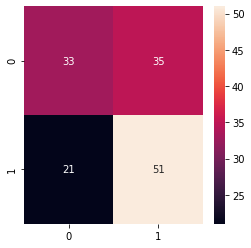

In [192]:
# stats for 'bad columns' data ("voting" model)
analyze_visualize('nn', handlers_bad_cols)


Statistics and Confusion Matrix for model "nn"
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       121
           1       0.82      0.81      0.81       149

    accuracy                           0.80       270
   macro avg       0.79      0.80      0.79       270
weighted avg       0.80      0.80      0.80       270



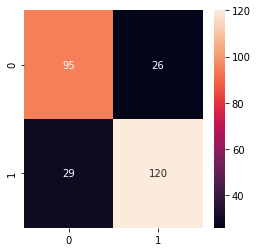

In [195]:
# stats for 'better columns' data ("voting" model)
analyze_visualize('nn', handlers_better_cols)

# Saving Models

In [200]:
save_models(handlers_bad_cols, "models\\bad_col_models")
save_models(handlers_better_cols, "models\\better_col_models")

PicklingError: Can't pickle <class '__main__.ModelHandler'>: it's not the same object as __main__.ModelHandler